## Data Augmentation Using Autoencoder Generated Data

---

_24th Feb 2018_<br>
_Cheo Rui Ming (SG)_<br>
_Refer [here](google.com.sg) for the accompanying notes. This blog is an extension of the [blog](https://cheorm.github.io/GAN-Credit-Card-Fraud) on the usage of GANs to augment data._<br>

---

Following the usage of GANs to augment a highly imbalanced dataset, a classical autoencoder was implemented with its performance evaluated.

In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

# Suppresses warnings
# Warnings were noted prior to cleaning up the notebook, suppressing them are for aesthetics
import warnings
warnings.filterwarnings(action='ignore')

import time
import json
import copy
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from timeit import default_timer as timer
from numba import vectorize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from imblearn import pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks

# Initialise seed value - 42
seed = 42
random.seed(42)
tf.set_random_seed(seed)
np.random.seed(seed)
sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Autoencoder Class

In [2]:
class Autoencoder(object):
    """ Invoke methods in sequential order. Implements a two layered (== 4 layers) autoencoder network """
    
    def __init__(self, learning_rate=0.01, batches=50, outer_nodes=500, inner_nodes=100, X_nodes=30):
        
        # Inputs, steps and train size
        self.train_step_, self.batch_, self.X_node_ = learning_rate, batches, X_nodes
        
        tf.set_random_seed(42)
        
        # Placeholder, weights & biases       
        self.X_ = tf.placeholder("float", [None, X_nodes]) 

        self.weights_ = {'encoder_h1': tf.Variable(xavier_init([X_nodes, outer_nodes], 'en_w1', tf.float32)),
                         'encoder_h2': tf.Variable(xavier_init([outer_nodes, inner_nodes], 'en_w2', tf.float32)),
                         'decoder_h1': tf.Variable(xavier_init([inner_nodes, outer_nodes], 'de_w1', tf.float32)),
                         'decoder_h2': tf.Variable(xavier_init([outer_nodes, X_nodes], 'de_w2', tf.float32))
                        }
        self.biases_ = {'encoder_b1': tf.Variable(tf.random_normal([outer_nodes])),
                        'encoder_b2': tf.Variable(tf.random_normal([inner_nodes])),
                        'decoder_b1': tf.Variable(tf.random_normal([outer_nodes])),
                        'decoder_b2': tf.Variable(tf.random_normal([X_nodes]))
                       }
        
        # Connected layers, predictions & losses
        self.encoder_op_, self.decoder_op_ = None,  None
        self.y_pred_, self.y_true_ = None, None
        self.loss_, self.optimizer_ = None, None
        
        # Fully connect encoder/decoder layers
        self.decode_out_ = None

    # Building the encoder
    def encode_decode(self):
        # Encoder Hidden layer with sigmoid activation #1
        enlayer_1 = tf.nn.tanh(tf.add(tf.matmul(self.X_, self.weights_['encoder_h1']),
                                       self.biases_['encoder_b1']))
        # Encoder Hidden layer with sigmoid activation #2
        enlayer_2 = tf.nn.tanh(tf.add(tf.matmul(enlayer_1, self.weights_['encoder_h2']),
                                       self.biases_['encoder_b2']))
        
        # Decoder Hidden layer with sigmoid activation #1
        delayer_1 = tf.nn.tanh(tf.add(tf.matmul(enlayer_2, self.weights_['decoder_h1']),
                                       self.biases_['decoder_b1']))
        # Decoder Hidden layer with sigmoid activation #2
        delayer_2 = tf.nn.tanh(tf.add(tf.matmul(delayer_1, self.weights_['decoder_h2']),
                                       self.biases_['decoder_b2']))
        
        self.decode_out_ = delayer_2
        
    def autoen_pred(self):

        # Prediction
        self.y_pred_ = self.decode_out_
        # Targets (Labels) are the input data.
        self.y_true_ = self.X_

        # Define loss and optimizer, minimize the squared error
        self.loss_ = tf.reduce_mean(tf.pow(self.y_true_ - self.y_pred_, 2)) # Mean squared error as the loss function
        self.optimizer_ = tf.train.RMSPropOptimizer(self.train_step_).minimize(self.loss_)

### Helper Functions

In [3]:
def uniform_draw_feat_class(data_df, target_name, draw_size):
    """ Sample out 1 particular class out of the full data uniformly in a predefined sample size.
    === Segregate pandas dataframe into their respective target classes === """
    
    # Break down full dataset into their respective classes
    target_class_dfs = {}
    n_classes = data_df[target_name].unique()
    
    for unique_class in n_classes:
        # Store each segregated class dataframes as dictionary
        class_i_df = data_df[data_df[target_name] == unique_class]
        class_i_df = (class_i_df.reset_index()).drop(columns=['index'])
        target_class_dfs[unique_class] = class_i_df
        
    # Obtain uniform samples of size 'draw_size' and store as dictionary
    uniform_class_sample_draws = {}
    
    # Pandas df. sampling default None equivalently uniform draws
    for unique_class in n_classes:
        unif_samples = target_class_dfs[unique_class].sample(n=draw_size, replace=True)
        sample_df = pd.DataFrame(unif_samples, columns=data_df.columns)    
        uniform_class_sample_draws[unique_class] = unif_samples
    
    # Returns dictionary of pandas dataframes, split into respective classes
    return uniform_class_sample_draws

def xavier_init(size, label, data_type):
    """ For usage in tensorflow neural nets weights initialisation per layer.
    Helps resolve issue of overfitting to data. """
    
    tf.set_random_seed(42)
    in_dim = size[0]; out_dim = size[1]
    xavier_stddev = 1. / tf.sqrt((in_dim + out_dim) / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev, name=label, dtype=data_type)

def steady_epoch(loss_lst, num_epochs_ran, sd_fluc_pct=0.15, scan_frame=225, minmax=min):   
    """ 
    FOR THE PURPOSE OF FINDING A FRAME OF EPOCHS WHERE THE LOSSES HAS STABILISED WITHIN SPECIFIED PERCENTAGE OF 
    1SD OF LOSSES FOR ALL EPOCHS EXECUTED
    
    DEFAULT FRAME OF EPOCHS WHERE LOSS IS CONSIDERED STEADY IS 225, FLUCTUATING WITHIN +/- 15% OF 1 S.D. OF THE LOSSES
    
    MINMAX OPTION PRESENT AS THE LIST OF LOSSES MAY ALL BE NEGATIVE (GENERATOR LOSSES), THEN WE WOULD WANT THE MAXIMUM
    
    [EXAMPLE - 5% OF S.D., 5% OF TOTAL EPOCHS RAN]
    Obtain minimum of losses and its corresponding 1 s.d. of loss of the given array of losses
    Do for a list of losses
        For some 5% out of all epochs ran
            if that particular 5% of epochs have losses each within +/-5% of the minimum loss,
                Epoch frame chosen as steady epoch-period
                Else return 'no steady epoch-periods found'; break
        Return frame of epochs found 
    """
    # Obtain minimum and s.d. value of the losses for all epochs
    loss_1sd = np.std(loss_lst)
    minmax_loss = minmax(loss_lst)

    epoch_frame_start = 0
    epoch_frame_end = epoch_frame_start + scan_frame
    
    # Return nothing in the event no frame of losses are found to have steady losses
    steady_frame=None
    
    # For loop termination
    exit_loop = True
    while exit_loop:

        # Reset counter when one of the epoch is not within +/-'sd_fluc_pct'% of minimum losses
        counter_5pct = 0

        for epoch in range(epoch_frame_start, epoch_frame_end, 1):
            if (loss_lst[epoch] > minmax_loss and loss_lst[epoch] <= (minmax_loss + sd_fluc_pct*loss_1sd)) \
            or (loss_lst[epoch] < minmax_loss and loss_lst[epoch] >= (minmax_loss - sd_fluc_pct*loss_1sd)):
                
                # Increase counter progressively until all (225) epochs in 'scan_frame' are within specified tolerance
                counter_5pct += 1

                # When (225) epochs are within +/-'sd_fluc_pct'% of minimal loss, flag the (225th) final epoch
                if counter_5pct == scan_frame:
                    print('Steady epoch frame found at epoch {} as final'.format(epoch_frame_end))
                    
                    # Return numpy array of epoch numbers within (225) specified range
                    steady_frame = np.linspace(start=(epoch_frame_end-scan_frame+1), stop=epoch_frame_end, num=scan_frame)
                    exit_loop = False
                    break           
            else:
                break

        # When a frame of 225 epochs within +/-'sd_fluc_pct'% of minimum losses is not found,
            # shift to next frame by 1 epoch
        epoch_frame_start += 1
        epoch_frame_end += 1

        if epoch_frame_end > num_epochs_ran:
            print('No steady epoch frame found!')
            break

    return steady_frame

### Preliminary Overview of Data

In [4]:
### Load credit card data and preprocessing ###

# Import 'creditcard.csv'
credit_csv_dir = 'creditcard.csv'
credit = pd.read_csv(credit_csv_dir)

# Convert data into 'mini-batchable' numpy NORMAL arrays, drop 'Time'
credit_X = credit.drop(labels=['Time','Class'], axis='columns')
credit_y = credit['Class'].as_matrix()

# Train-test split data: 75/25
X_train, X_test, y_train, y_test = train_test_split(credit_X, credit_y, test_size=0.25, random_state=seed)

From the given dataset, the aim is to detect frauds regardless of time, otherwise the underlying detection method would not be able to pick up frauds if fraudsters change their time of operation.
- Time will be dropped for the sake of creating a model that can detect fraudulent transactions regardless of the time of day

It may be thought that 'Amount' should also be removed since fraudulent transaction amounts may be a subset of normal transaction amounts. Regardless, we shall perform statistical tests to determine feature relevance and to verify whether unique transaction 'Amount' patterns in fraudulent ones exist.

In [12]:
### Overview of data in 'credit' ###

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('max_info_columns', 1000)
pd.set_option('max_info_rows', 1000)

# 1st 5 rows
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [11]:
# Dtype; checking for nulls
credit.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [10]:
# Descriptive statistics
credit.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,1.673327e-15,-1.254995e-15,8.176030e-16,1.206296e-15,4.913003e-15,1.437666e-15,-3.800113e-16,9.572133e-16,1.039817e-15,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
# Validate only fraud and non-fraud classes
credit['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

As defined from source: 'Time' is the seconds elapsed between each transaction and the first transaction in the dataset. The last transaction was 172,792 seconds after the first was made. This computes to approximately 2 days' worth of transaction data.

In this case, it is unknown during what time of the day the transactions actually began. Then, it is not possible to say that the first data point of 'Time' value == 0 imply transactions began at midnight. The column can at most inform us how close the transactions were made in between 2 fraudulent ones.

Since the aim is to predict frauds regardless of transaction time, 'Time' was dropped earlier.

#### Managing train-test split data

As 'V1' to 'V28' were obtained via PCA-transformation of the original features to anonymise the clientele, only 'Amount' needs to be standardised for the sake of consistency of the entire dataset

Also, the 'Amount' columns of both the training and test set are standardised based on the training set's mean and standard deviations. This is done so to model reality where the characteristics of the test set is unknown to us. If the training set is a good representative of reality, then there should not be any differences between itself and the unlabelled (fraud/non-fraud) data.

In [10]:
# Labels
X_cols = list(credit.drop(labels=['Time', 'Class'], axis='columns').columns)
y_cols = credit[['Class']].columns
target_names = credit['Class'].map(lambda x: 'Non-Fraud' if x==0 else 'Fraud').unique()

# Training data as dataframe
X_train_df = pd.DataFrame(X_train, columns=X_cols)
X_train_df['Amount'] = StandardScaler().fit_transform(X_train_df['Amount'].as_matrix().reshape(-1, 1))
X_train_df = X_train_df.reset_index().drop(columns=['index'])
y_train_df = pd.DataFrame(y_train, columns=y_cols)
# Full dataframe
train_df = pd.concat([X_train_df, y_train_df], join='outer', axis='columns')
# X, y as numpy array
X_train, y_train = X_train_df.as_matrix(), y_train_df.as_matrix()

# Test data as dataframe
X_test_df = pd.DataFrame(X_test, columns=X_cols)
X_test_df['Amount'] = StandardScaler().fit(X_train_df['Amount'].as_matrix().reshape(-1, 1)).transform(X_test_df['Amount'].as_matrix().reshape(-1, 1))
X_test_df = X_test_df.reset_index().drop(columns=['index'])
y_test_df = pd.DataFrame(y_test, columns=y_cols)
# Full dataframe
test_df = pd.concat([X_test_df, y_test_df], join='outer', axis='columns')
# X, y as numpy array
X_test, y_test = X_test_df.as_matrix(), y_test_df.as_matrix()

In [11]:
# Check number of frauds in both training and testing data
print('Number of frauds in training data: {} out of {} cases ({:.10f}% fraud)'.format(np.sum(y_train), y_train.shape[0], np.mean(y_train)*100))
print('Number of frauds in test data: {} out of {} cases ({:.10f}% fraud)'.format(np.sum(y_test), y_test.shape[0], np.mean(y_test)*100))

Number of frauds in training data: 379 out of 213605 cases (0.1774303036% fraud)
Number of frauds in test data: 113 out of 71202 cases (0.1587034072% fraud)


Examine the total value of 'Amount' in all the fraud transactions in both the training and test datasets.

In [12]:
# Train test split as how data was done earlier
X_amt_tr, X_amt_te, y_amt_tr, y_amt_te = train_test_split(credit.drop(columns=['Class']).as_matrix(), 
                                                          credit['Class'].as_matrix(), 
                                                          test_size=0.25, 
                                                          random_state=42)

# Create dataframes
amt_tr = np.concatenate((X_amt_tr, y_amt_tr.reshape(-1, 1)), axis=1)
amt_tr_df = pd.DataFrame(amt_tr, columns=credit.columns)
amt_te = np.concatenate((X_amt_te, y_amt_te.reshape(-1, 1)), axis=1)
amt_te_df = pd.DataFrame(amt_te, columns=credit.columns)

# Training Set Fraud 'Amount' Sum
tl_tr_fraud_amt = amt_tr_df[amt_tr_df['Class'] == 1]['Amount'].sum()
# Test Set Fraud 'Amount' Sum
tl_te_fraud_amt = amt_te_df[amt_te_df['Class'] == 1]['Amount'].sum()
print('Total "Amount" in training set: ${} | Total "Amount" in test set: ${}'.format(np.round(tl_tr_fraud_amt, 2), 
                                                                                     np.round(tl_te_fraud_amt, 2)))

Total "Amount" in training set: $42513.46 | Total "Amount" in test set: $17614.51


### Exploratory Data Analysis (Training Set Only)

A PCA plot was implemented to observe for the differences between fraudulent and normal transactions.

explained variance ratio (first two components): [ 0.12503723  0.10004168]


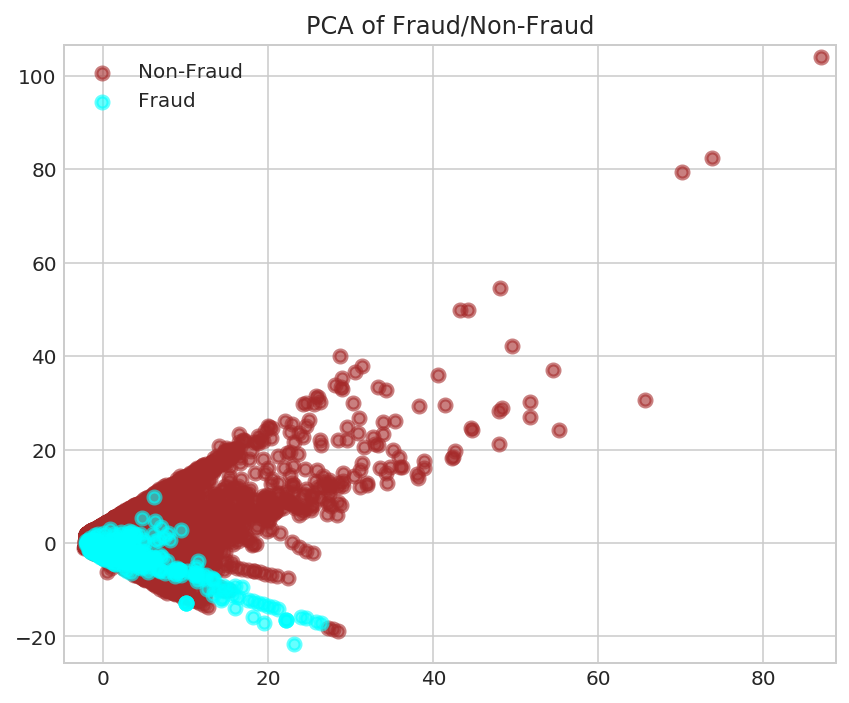

In [8]:
# 2-component PCA plot
    # PCA is sensitive to dimensional scales, thus the need to standardise matrix X
X_pca = copy.deepcopy(X_train)
y_pca = copy.deepcopy(y_train).reshape(-1, )

pca = PCA(n_components=2, random_state=seed)
X_r = pca.fit_transform(X_pca)

# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

plt.figure(figsize=(6,5)); colors = ['brown', 'cyan']; lw = 2

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y_pca == i, 0], X_r[y_pca == i, 1], color=color, alpha=.6, lw=lw, label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Fraud/Non-Fraud')
plt.tight_layout(); plt.margins(0.02)

Clearly some form of distinction between fraud and non-fraud data exits. However, since the fraud data is a subset of the non-frauds (i.e. fraudulent clusters within the area of the non-fraud clusters), it will not be unexpected to find the precision of identifying fraud data to be exceptionally poor when maximising recall.

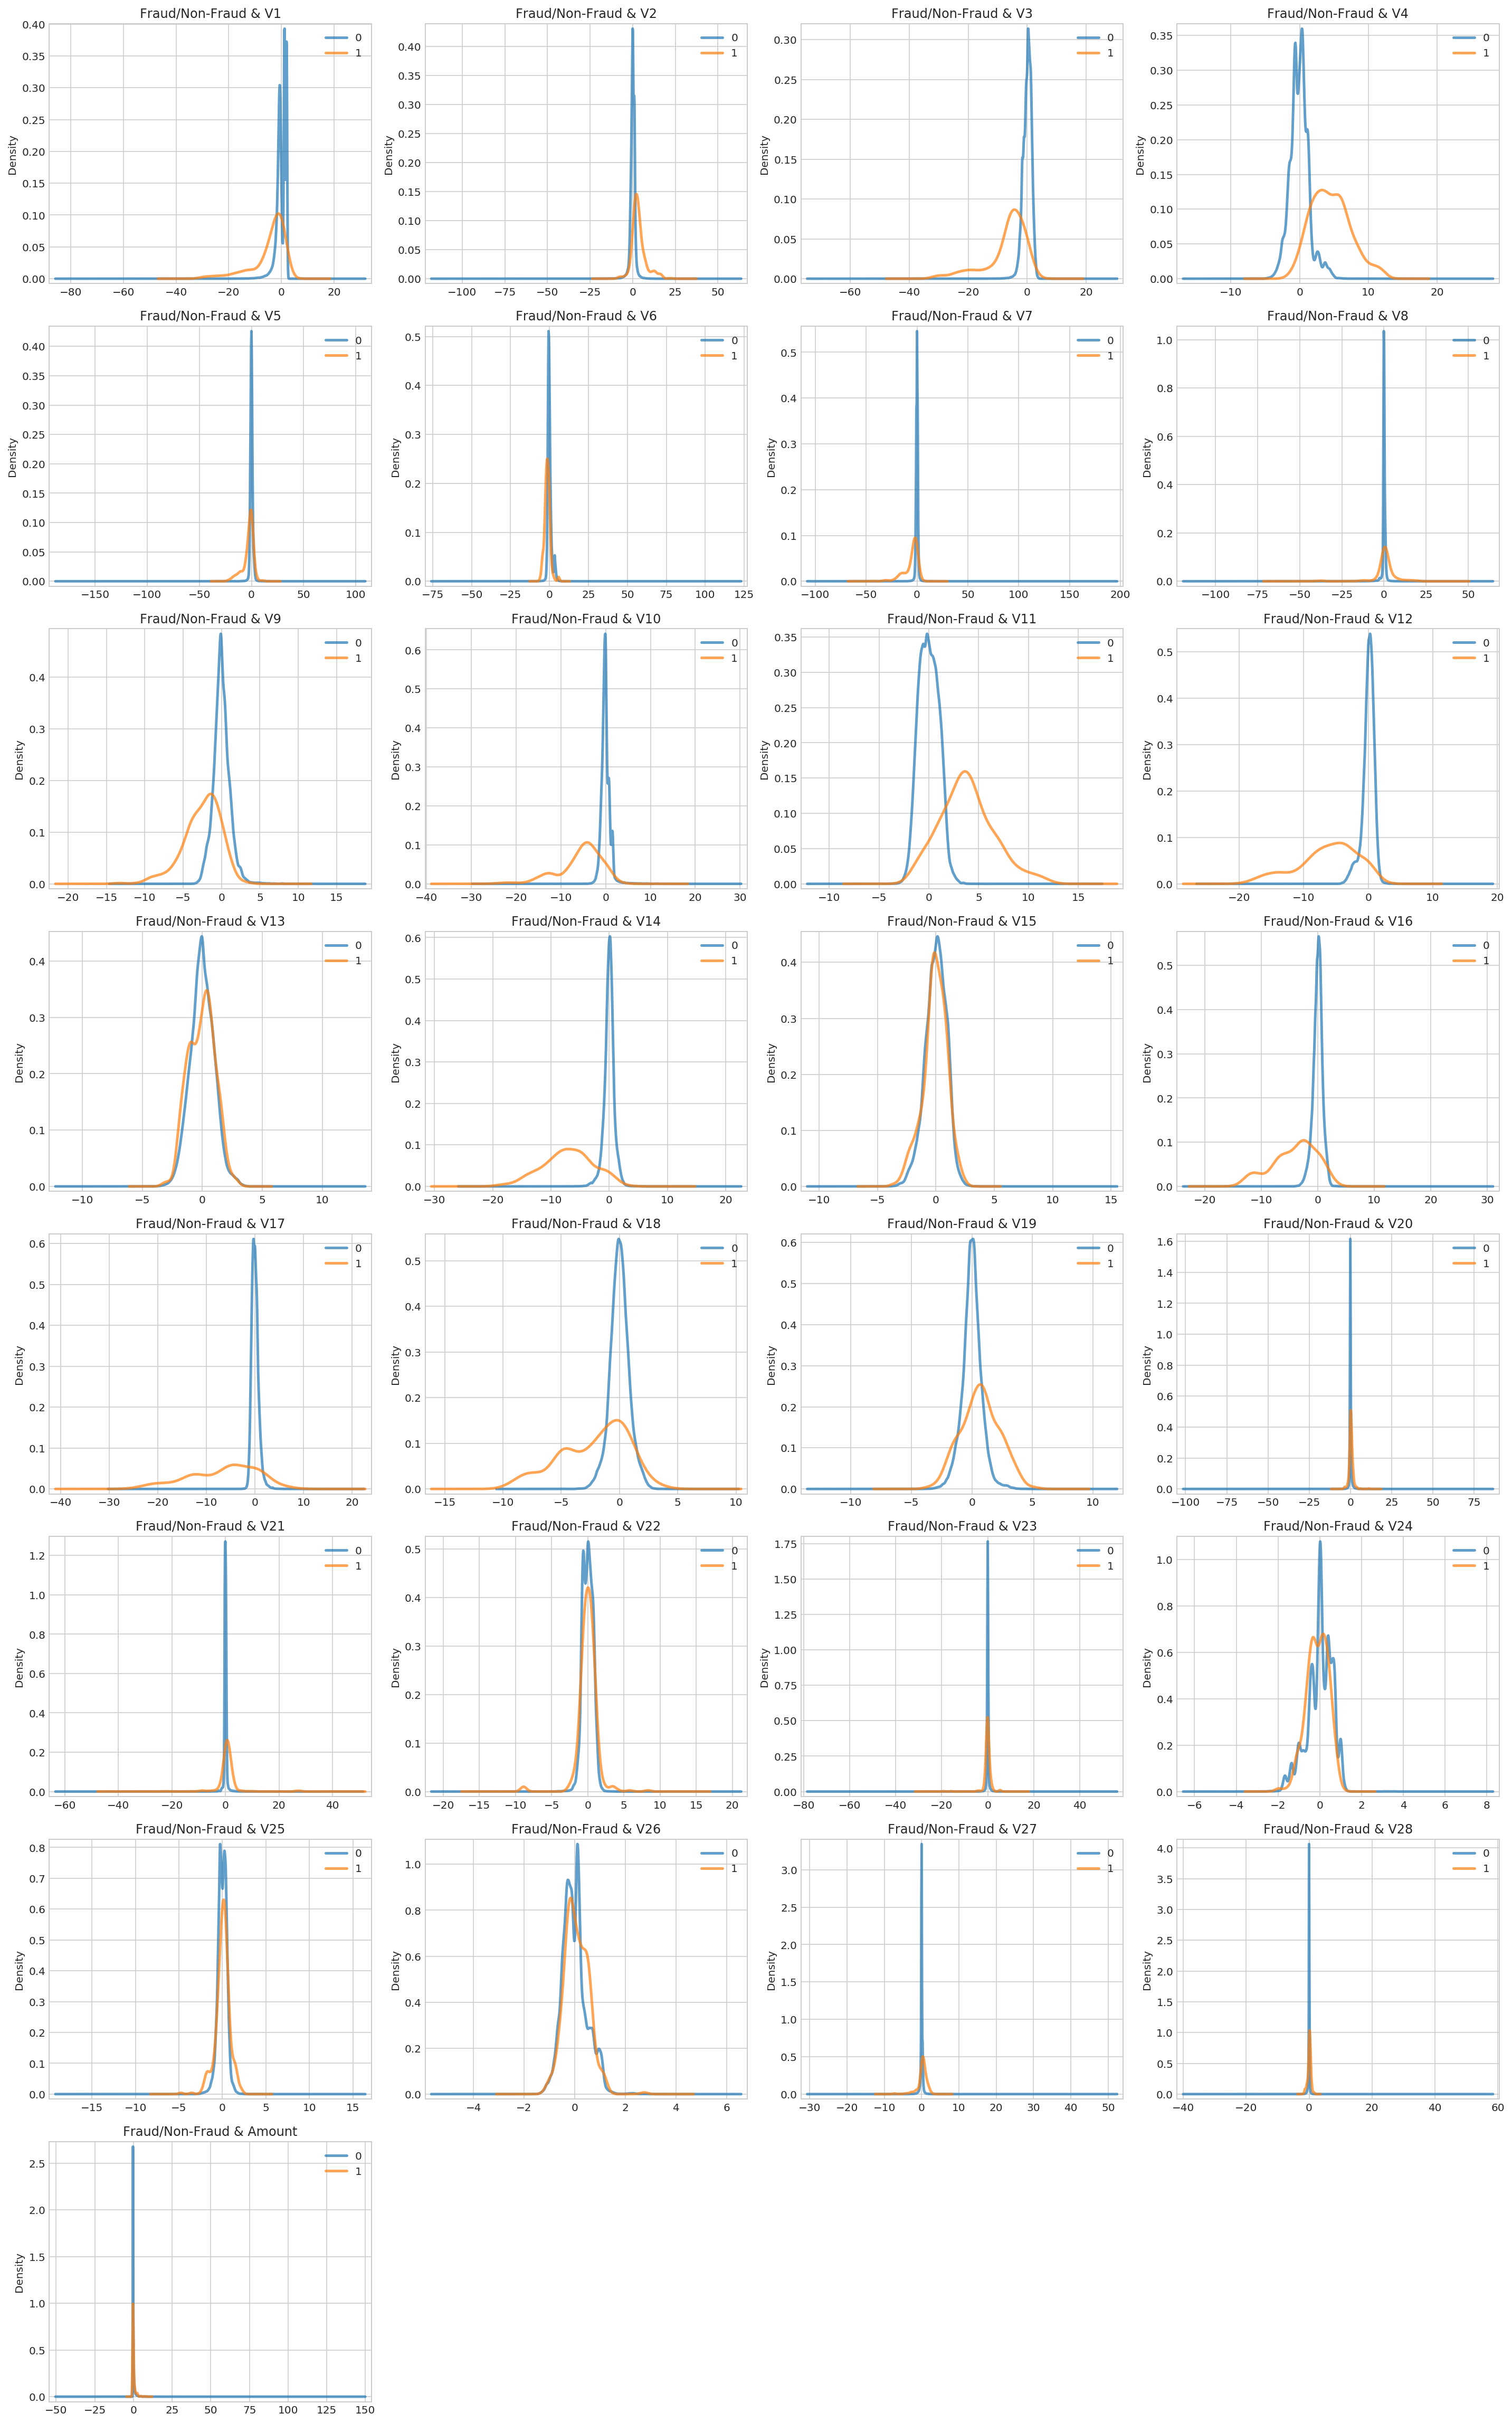

In [9]:
# Kernel Density Distribution subplots against target - 'Class'

# Scatter subplots
plt.figure(figsize=(20,32))
for plot, feat in enumerate(X_cols):
    
    plt.subplot(8, 4, (plot+1))
    title = 'Fraud/Non-Fraud & ' + feat
    
    # Normalise to visualise the differences in distributions
    temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
    temp_df.groupby(by='Class')[feat].plot(kind='kde', alpha=0.7, legend='best', lw=2.5)
    plt.title(title)
    plt.tight_layout(); plt.margins(0.02)
    
plt.show()    

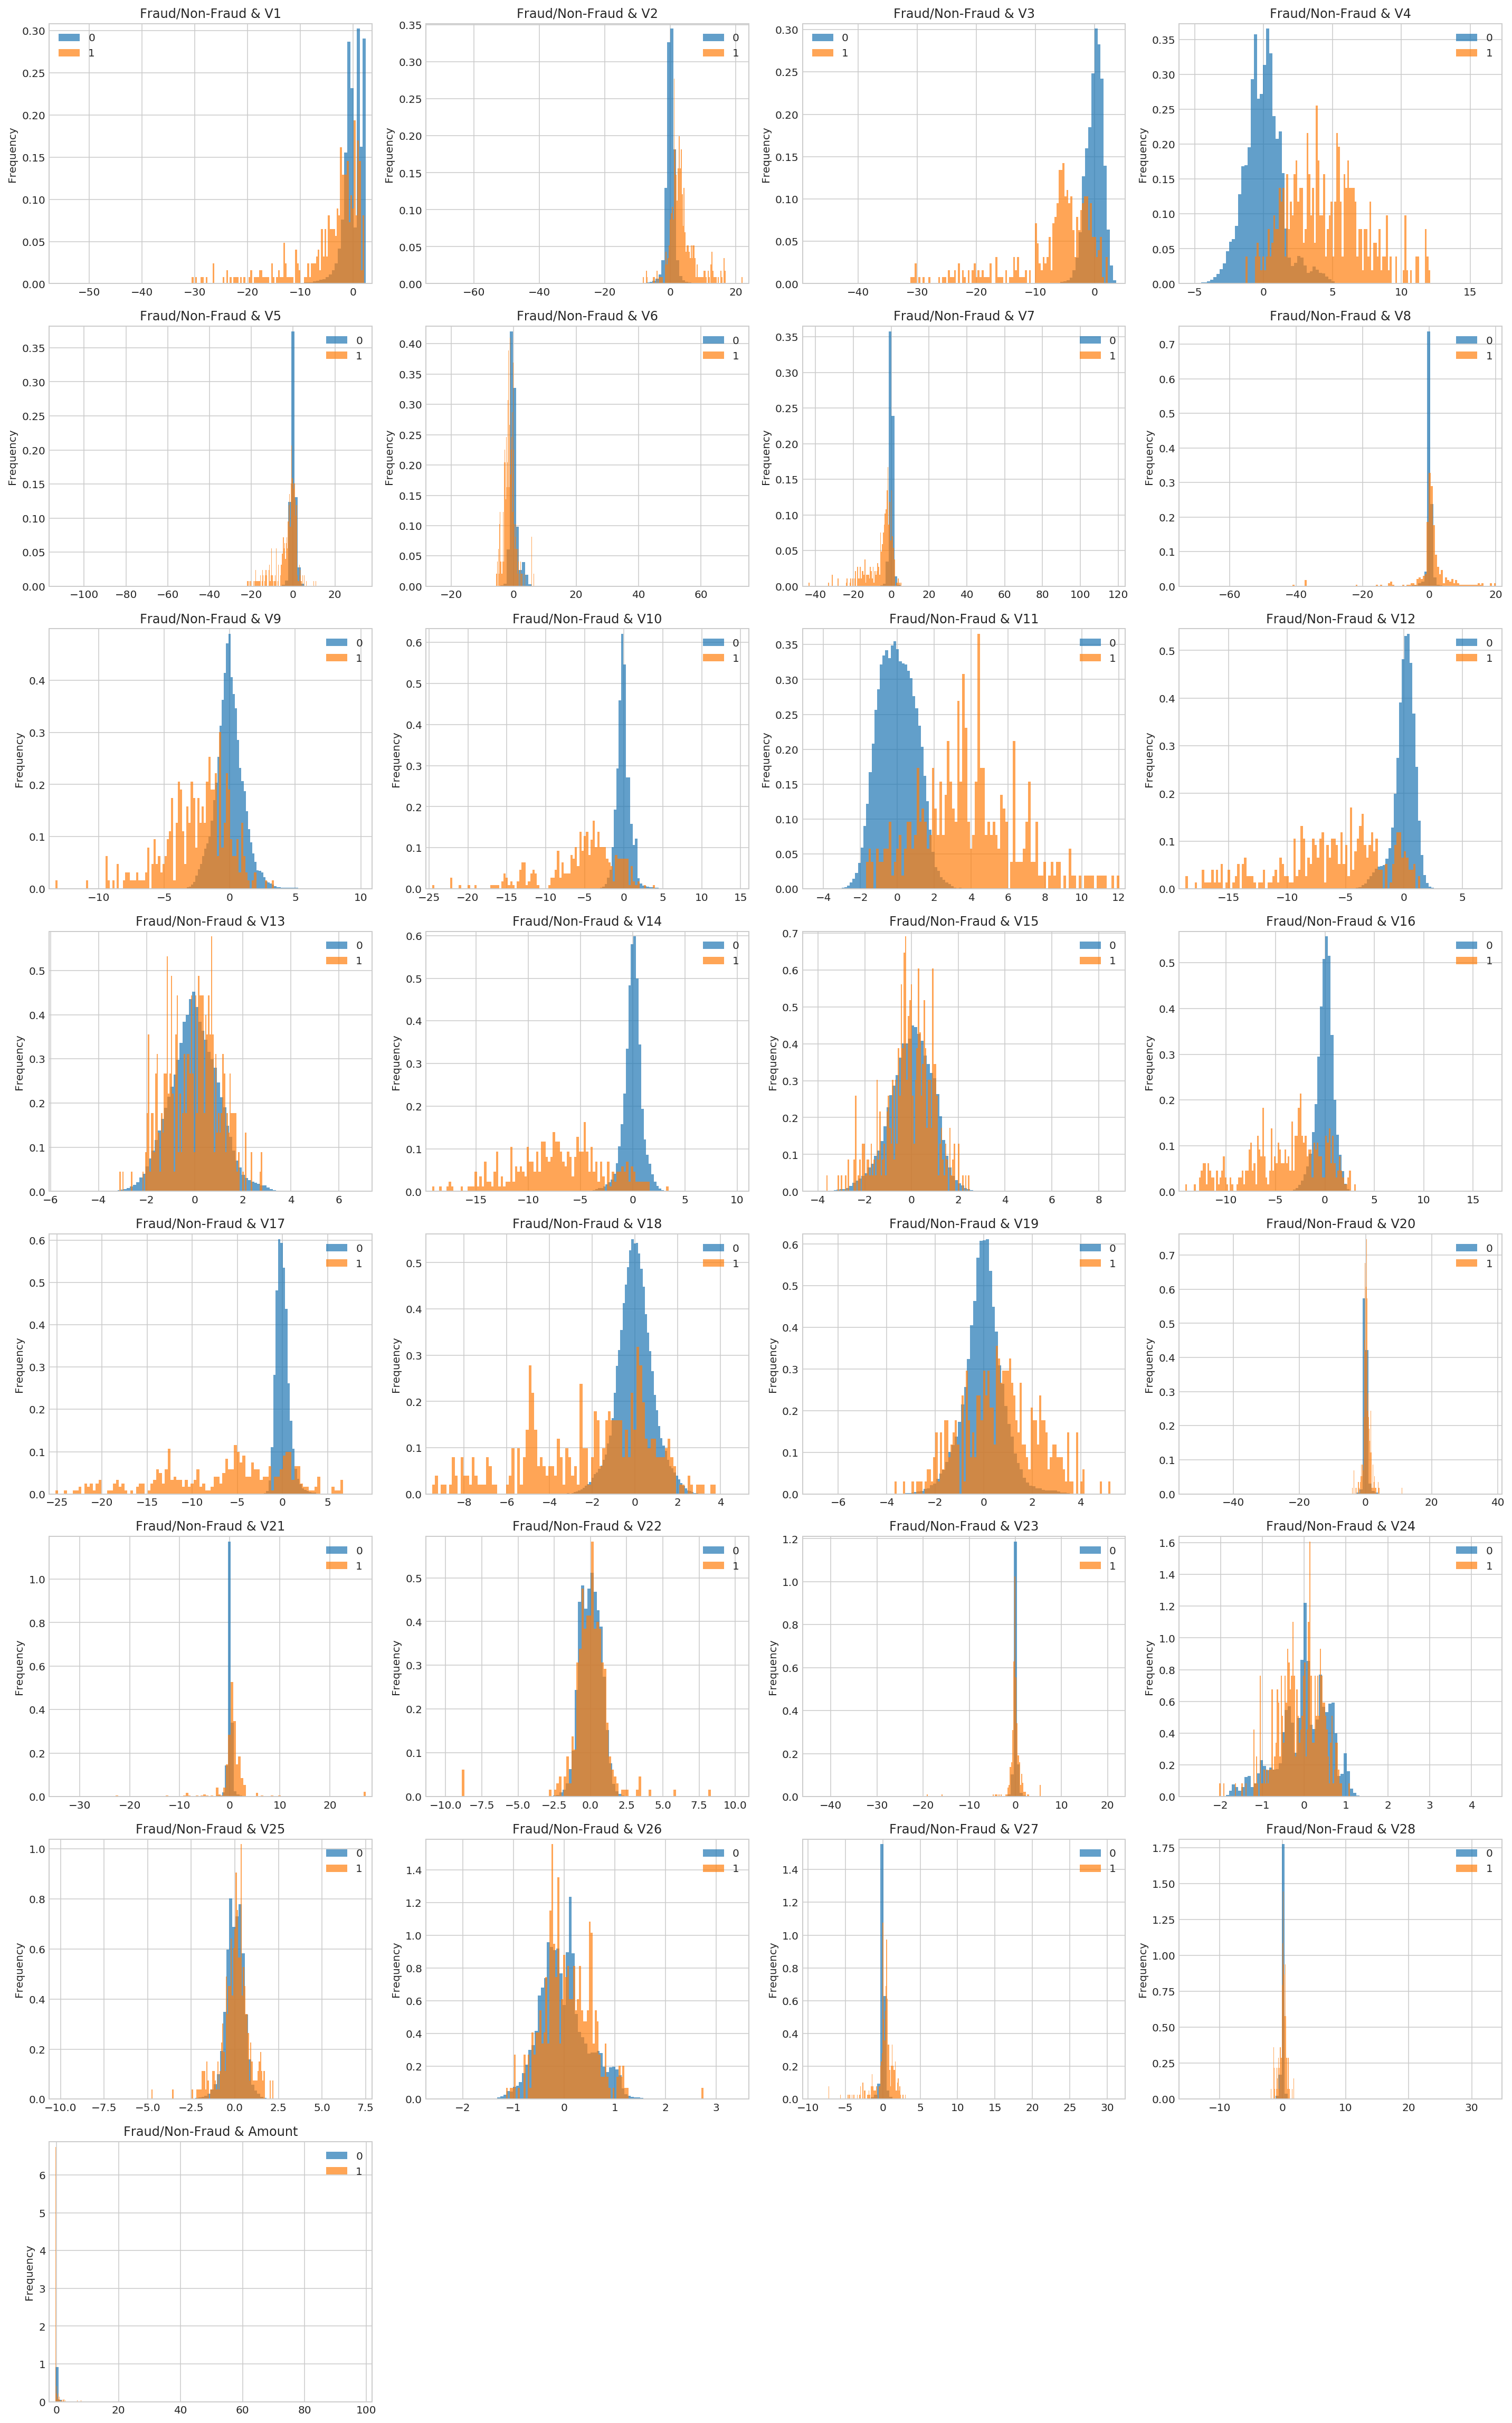

In [10]:
# Histogram Distribution subplots against target - 'Class'

# Scatter subplots
plt.figure(figsize=(20,32))
for plot, feat in enumerate(X_cols):
    
    plt.subplot(8, 4, (plot+1))
    title = 'Fraud/Non-Fraud & ' + feat
    
    # Normalise to visualise the differences in distributions
    temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
    temp_df.groupby(by='Class')[feat].plot(kind='hist', bins=100, alpha=0.7, 
                                           legend='best', normed=True)
    plt.title(title)
    plt.tight_layout(); plt.margins(0.02)
    
plt.show()    

Based on the distribution graphs above, it appears that for certain features, the distribution of fraudulent cases are different from non-fraudulent cases. However, the differences are difficult to make definitive judgements based on visual inspection.

For the sake of reaching a robust conclusion (on which features are important to distinguish normal transactions from fraudulent ones), we will perform equality of distribution tests. In this case, the Wilcoxon Rank-Sum Test is chosen here since outliers were found in the data. This will be used to check for equality of the distributions of each feature, between fraud and non-fraud cases.

In [13]:
# Perform Wilcoxon Rank-Sum Test at 5% Level to determine feature relevance

# Keep results if needed later
wilcox_result = dict([])

for feat in X_cols:   
    temp_df = pd.concat([X_train_df[[feat]], y_train_df], axis='columns')
    
    # Draw 300 samples (only 379 fraud data in training set, attempt to draw close to the hilt)
    random.seed(42)
    fraud_wilcox = random.sample(list(temp_df[temp_df['Class']==1][feat]), k=300)
    nonfraud_wilcox = random.sample(list(temp_df[temp_df['Class']==0][feat]), k=300)
    
    rank_sums, p_val_wilcox = stats.wilcoxon(fraud_wilcox, nonfraud_wilcox)
    
    if p_val_wilcox > 0.05:
        wilcox_result[feat] = ('No_Diff', p_val_wilcox)
    else:
        wilcox_result[feat] = ('Diff', p_val_wilcox)
        
    print('Feature "{}" with p-value {:.10f}'.format(feat, p_val_wilcox))
    
# Rank-Sum Test determined differences in classes within feature
wilcox_feat = [feat for feat in wilcox_result.keys() if wilcox_result[feat][0] == 'Diff']
print('\n', 'Wilcoxon Rank-Sum Relevant Features: ', wilcox_feat)
print('Total number of features selected: {}'.format(len(wilcox_feat)))

Feature "V1" with p-value 0.0000000000
Feature "V2" with p-value 0.0000000000
Feature "V3" with p-value 0.0000000000
Feature "V4" with p-value 0.0000000000
Feature "V5" with p-value 0.0000000000
Feature "V6" with p-value 0.0000000000
Feature "V7" with p-value 0.0000000000
Feature "V8" with p-value 0.0000000503
Feature "V9" with p-value 0.0000000000
Feature "V10" with p-value 0.0000000000
Feature "V11" with p-value 0.0000000000
Feature "V12" with p-value 0.0000000000
Feature "V13" with p-value 0.0973465482
Feature "V14" with p-value 0.0000000000
Feature "V15" with p-value 0.8092477538
Feature "V16" with p-value 0.0000000000
Feature "V17" with p-value 0.0000000000
Feature "V18" with p-value 0.0000000000
Feature "V19" with p-value 0.0000000029
Feature "V20" with p-value 0.0000000014
Feature "V21" with p-value 0.0000000000
Feature "V22" with p-value 0.3224055980
Feature "V23" with p-value 0.7011952304
Feature "V24" with p-value 0.0103595269
Feature "V25" with p-value 0.0480350700
Feature "

In [14]:
unselected_feats = list(set(X_cols).difference(wilcox_feat))
print('Unselected features: {}'.format(unselected_feats))

Unselected features: ['V15', 'V23', 'V22', 'V26', 'V13', 'Amount']


#### Results from Wilcoxon Rank-Sum Tests:
* The null hypothesis is rejected at 5% significance for all features
* Features that are removed: 'V15', 'V22', 'V26', 'V13', 'V23', 'Amount'

The top 6 most correlated feature pairs, each feature selected by the Wilcoxon tests, were plotted to visualise the scatter patterns.

In [15]:
# Obtain the top 6 most wilcoxon-selected correlated variables' to observe their scatter pair plot relations

# Check for high correlations
wilcox_corr = X_train_df.drop(columns=['V15', 'Amount', 'V13', 'V26', 'V22', 'V23']).corr().abs()
wilcox_corr_pdSr = wilcox_corr.unstack()
wilcox_corr_pdSr_sort = wilcox_corr_pdSr.sort_values(ascending=False).to_frame()

# Top 6 correlated variable pairs
wilcox_corr_pdSr_sort.iloc[23:35:2, :].rename(index=str, columns={0:'pearson_rho'})

pearson_rho
V5 V7     0.030143
V6 V5     0.016899
V7 V3     0.016640
   V6     0.016007
V2 V1     0.015015
V1 V7     0.012172

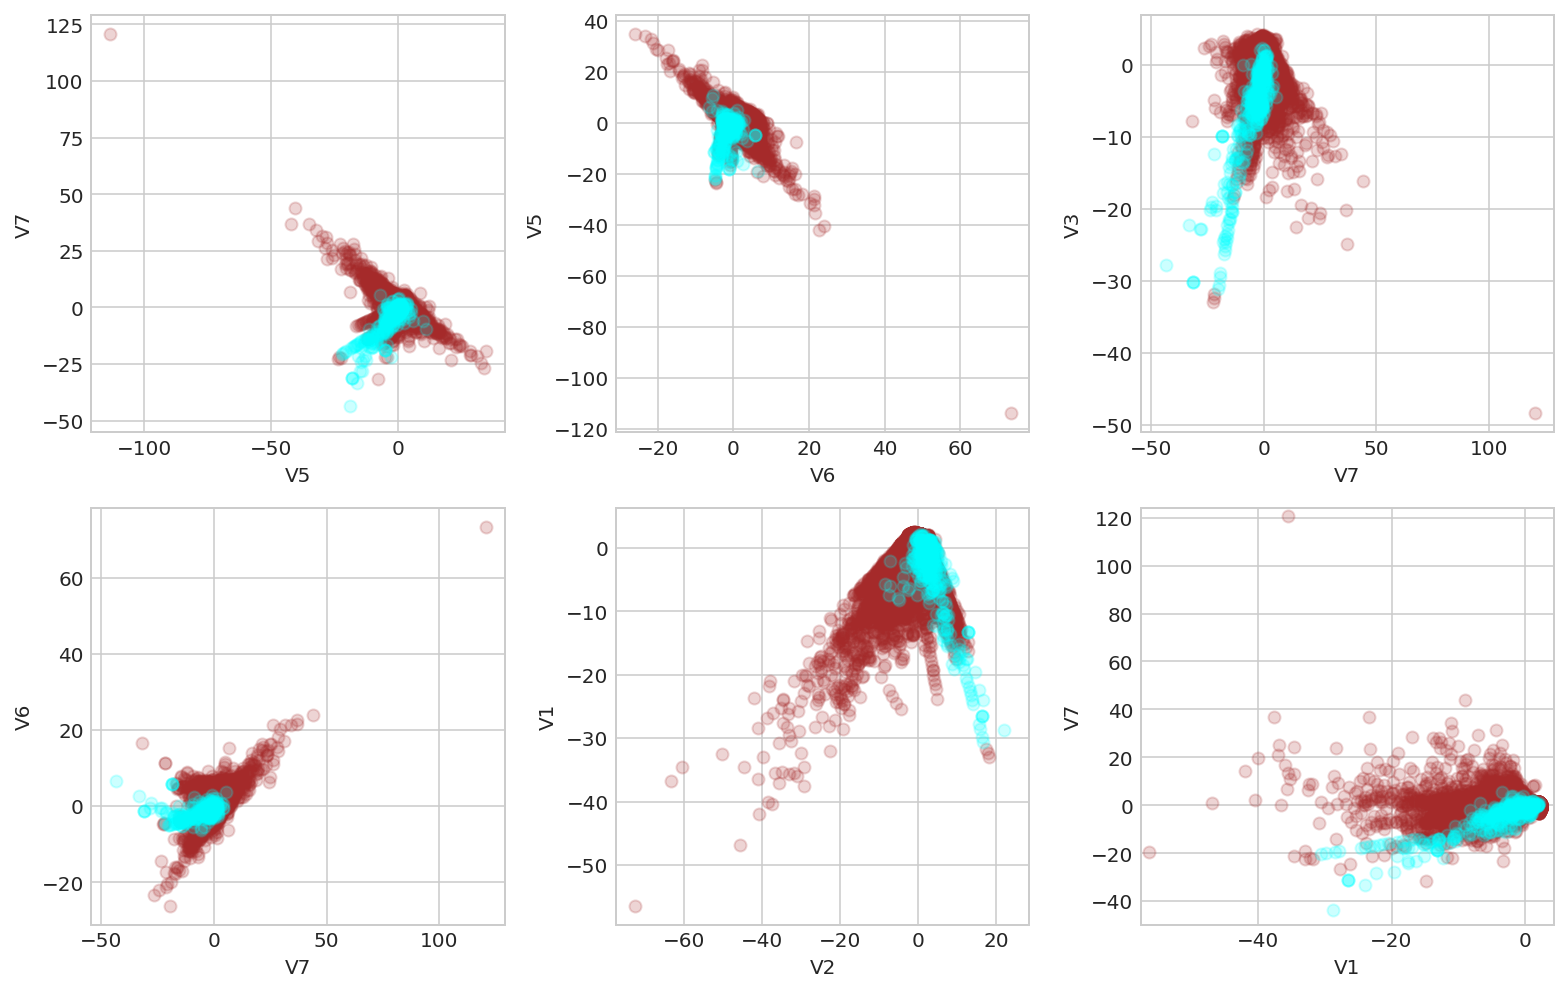

In [12]:
# Plot scatter plots of these 6 correlation pairs
corr_top6 = (('V5', 'V7'), ('V6', 'V5'), ('V7', 'V3'), ('V7', 'V6'), ('V2', 'V1'), ('V1', 'V7'))

plt.figure(figsize=(11, 7))
labels = ['non_fraud', 'fraud']; colors = ['brown', 'cyan']; lw = 2

for plot in range(6):
    plt.subplot(2, 3, (plot+1))
    
    for group, color, label, in zip(train_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], 
                    group[1][corr_top6[plot][1]], 
                    c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0]); plt.ylabel(corr_top6[plot][1])

plt.margins(0.02); plt.tight_layout()

#### Autoencoder Implementation of Data Augmentation

A simple autoencoder network was implemented to generate data for augmenting the dataset. With minimal tuning, it was executed for 6300 epochs. The epoch with the lowest MSE loss, frame of epochs with stabilised losses and the final epoch had their generated data retrieved for augmenting the training set's minority (fraud) class.

In [16]:
# Train parameters
learning_rate = 0.0001
auto_epochs = 6300
batch_size = 5000
X_feats = len(wilcox_feat)

# Create Autoencoder objects for fraud & fraudless filtering on the generated data
auto_fraudless = Autoencoder(X_nodes=X_feats, learning_rate=learning_rate) # Learning rate original 0.01
auto_fraudless.encode_decode(); auto_fraudless.autoen_pred()

auto_fraud = Autoencoder(X_nodes=X_feats, learning_rate=learning_rate) # Learning rate original 0.01
auto_fraud.encode_decode(); auto_fraud.autoen_pred()

In [14]:
seed = 42
random.seed(seed)
tf.set_random_seed(seed)
np.random.seed(seed)

# Measure Start Time
start_time = time.time()

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    # Execute initialisation
    sess.run(init)
    
    # Collect list of generator/discriminator losses
    auto_fraudless_loss, auto_fraud_loss = [], []
    
    # Collect generated fraudless/fraud data; Epoch as key, array as values
    auto_fraudless_X, auto_fraud_X = {}, {}

    # Training
    for epoch in range(auto_epochs):
        
        # Obtain batches of fraud/fraudless data
        split_df_dict = uniform_draw_feat_class(train_df, 'Class', batch_size)
        fraudless_X_mb = split_df_dict[0].drop(columns=['V15', 'V13', 'V23', 
                                                        'Amount', 'V26', 'V22', 'Class']).as_matrix().astype(np.float32)
        fraud_X_mb = split_df_dict[1].drop(columns=['V15', 'V13', 'V23', 
                                                    'Amount', 'V26', 'V22', 'Class']).as_matrix().astype(np.float32)

        # Run optimization op (backprop) and cost op (to get loss value)
        _, fraudless_loss = sess.run([auto_fraudless.optimizer_, auto_fraudless.loss_], 
                                     feed_dict={auto_fraudless.X_: fraudless_X_mb})
        
        _, fraud_loss = sess.run([auto_fraud.optimizer_, auto_fraud.loss_], 
                                     feed_dict={auto_fraud.X_: fraud_X_mb})
        # Store losses for analysis later
        auto_fraudless_loss.append(fraudless_loss)
        auto_fraud_loss.append(fraud_loss)
        
        # Display logs 1st and per 100 steps
        if (epoch+1) % 100 == 0 or (epoch+1) == 1:
            print('Epoch %i: FraudLESS Minibatch Loss: %f' % ((epoch+1), fraudless_loss))
            print('Epoch %i: Fraud Minibatch Loss: %f' % ((epoch+1), fraud_loss), '\n')
        
        # Obtain batches of fraud/fraudless data
        split_df_dict = uniform_draw_feat_class(train_df, 'Class', batch_size)
        fraudless_X_mb = split_df_dict[0].drop(columns=['V15', 'V13', 'V23', 
                                                        'Amount', 'V26', 'V22', 'Class']).as_matrix().astype(np.float32)
        fraud_X_mb = split_df_dict[1].drop(columns=['V15', 'V13', 'V23', 
                                                    'Amount', 'V26', 'V22', 'Class']).as_matrix().astype(np.float32)

        # Encode and decode to generate data
        fraudless_gen_X = sess.run(auto_fraudless.decode_out_, feed_dict={auto_fraudless.X_: fraudless_X_mb})
        fraud_gen_X = sess.run(auto_fraud.decode_out_, feed_dict={auto_fraud.X_: fraud_X_mb})
        # Store generated data
        auto_fraudless_X[epoch+1], auto_fraud_X[epoch+1] = fraudless_gen_X, fraud_gen_X
        
# Measure End Time
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

Epoch 1: FraudLESS Minibatch Loss: 1.669550
Epoch 1: Fraud Minibatch Loss: 32.313690 

Epoch 100: FraudLESS Minibatch Loss: 1.318847
Epoch 100: Fraud Minibatch Loss: 27.813030 

Epoch 200: FraudLESS Minibatch Loss: 0.720065
Epoch 200: Fraud Minibatch Loss: 26.776005 

Epoch 300: FraudLESS Minibatch Loss: 0.467442
Epoch 300: Fraud Minibatch Loss: 26.205416 

Epoch 400: FraudLESS Minibatch Loss: 0.444912
Epoch 400: Fraud Minibatch Loss: 26.228756 

Epoch 500: FraudLESS Minibatch Loss: 0.553196
Epoch 500: Fraud Minibatch Loss: 26.166412 

Epoch 600: FraudLESS Minibatch Loss: 0.504994
Epoch 600: Fraud Minibatch Loss: 25.940687 

Epoch 700: FraudLESS Minibatch Loss: 0.408695
Epoch 700: Fraud Minibatch Loss: 26.051561 

Epoch 800: FraudLESS Minibatch Loss: 0.434361
Epoch 800: Fraud Minibatch Loss: 26.484089 

Epoch 900: FraudLESS Minibatch Loss: 0.366144
Epoch 900: Fraud Minibatch Loss: 26.639833 

Epoch 1000: FraudLESS Minibatch Loss: 0.391412
Epoch 1000: Fraud Minibatch Loss: 26.810339 

E

In [15]:
### Saving data ###
# Pickle, save autoencoder losses
pd.to_pickle(auto_fraudless_loss, 'AUTO_Fraudless_Loss.pkl')
pd.to_pickle(auto_fraud_loss, 'AUTO_Fraud_Loss.pkl')

# Pickle, save autoencoder generated X
pd.to_pickle(auto_fraudless_X, 'AUTO_Fraudless_X.pkl')
pd.to_pickle(auto_fraud_X, 'AUTO_Fraud_X.pkl')

In [6]:
### Reading saved data ###
# Generated X
auto_fraudless_loss = pd.read_pickle('AUTO_Fraudless_Loss.pkl')
auto_fraud_loss = pd.read_pickle('AUTO_Fraud_Loss.pkl')
    
# Autoencoder Losses
auto_fraudless_X = pd.read_pickle('AUTO_Fraudless_X.pkl')
auto_fraud_X = pd.read_pickle('AUTO_Fraud_X.pkl')

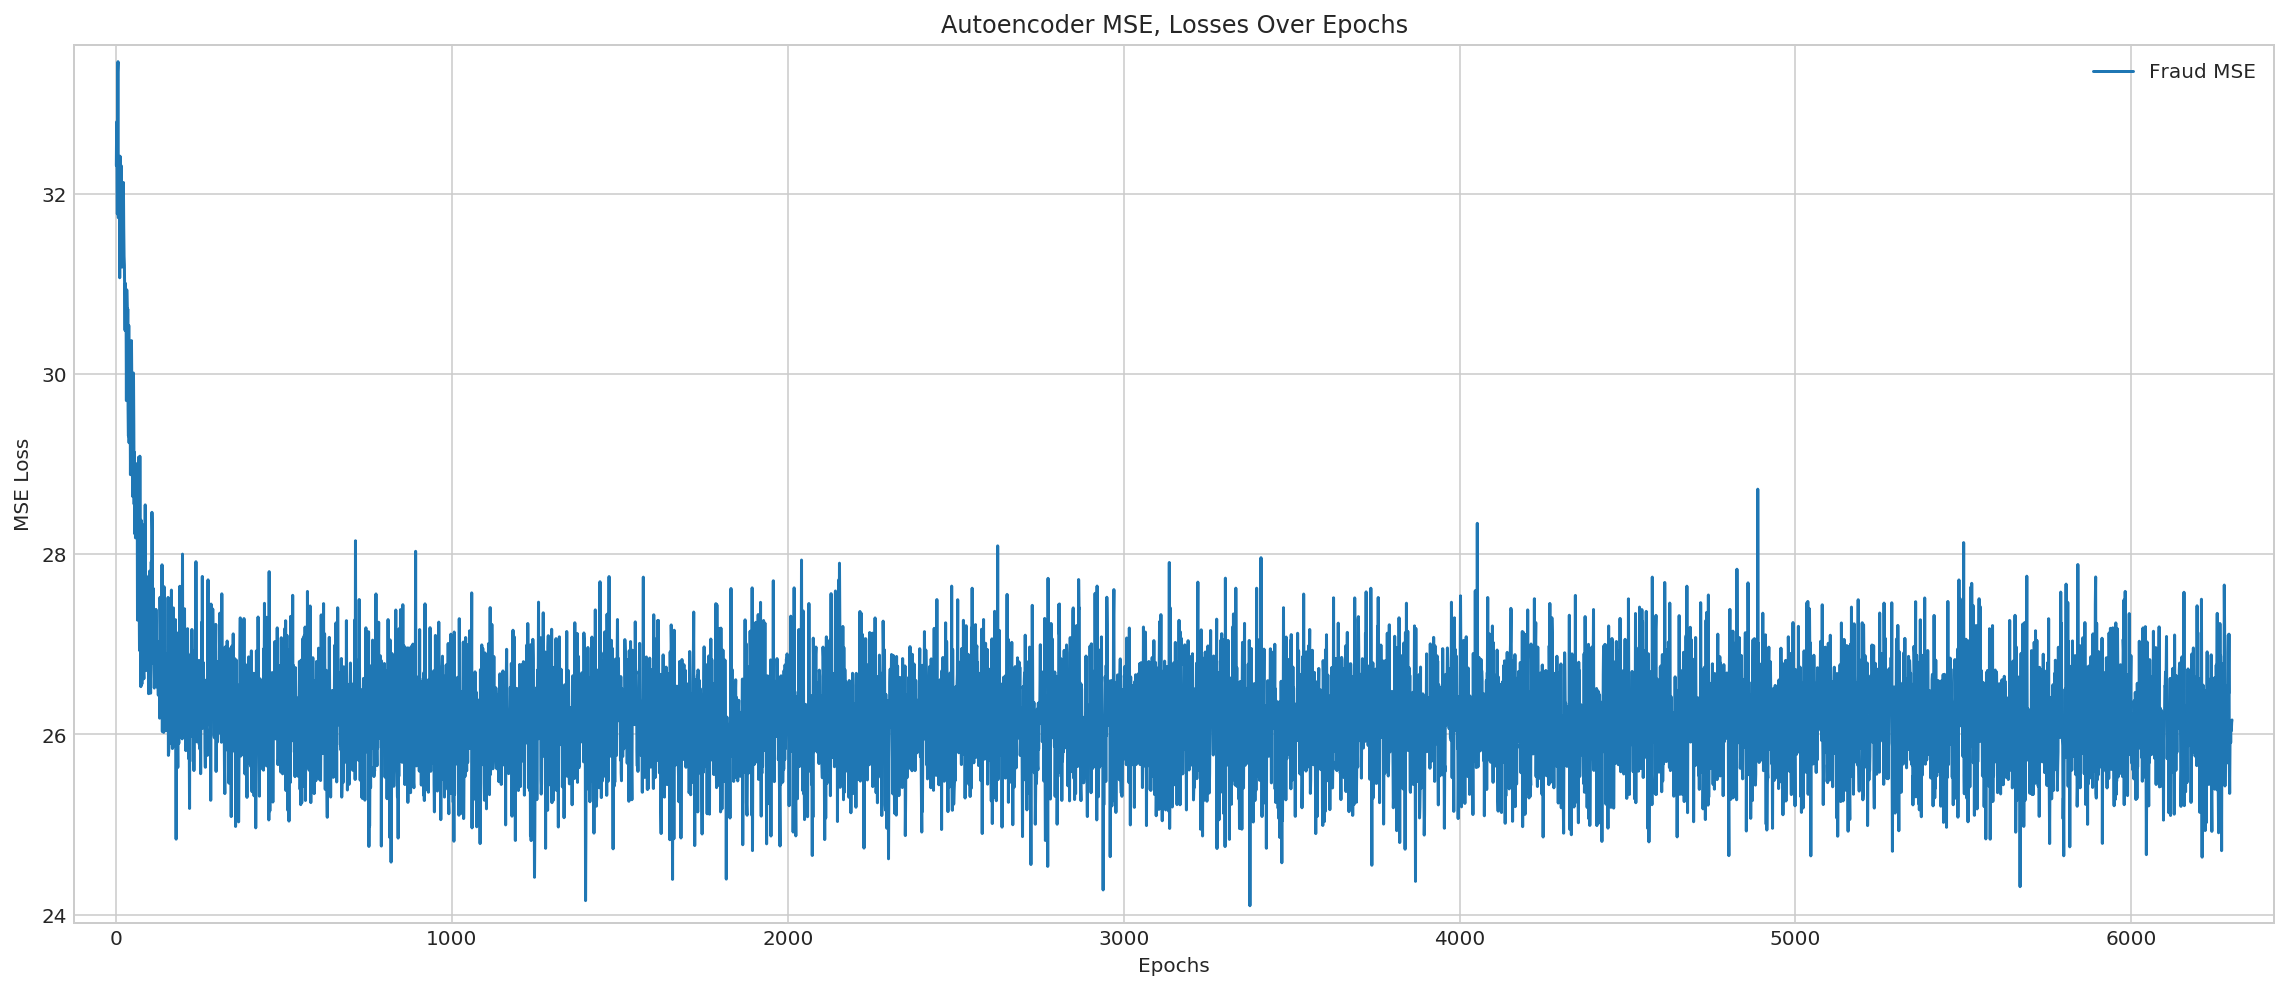

In [17]:
# Plot loss results
auto_epoch_axis = np.linspace(1, auto_epochs, num=auto_epochs)

# Plot discriminator/generator losses of fraud/fraudless beside each other
_ = plt.figure(figsize=(16,7))
_ = plt.plot(auto_epoch_axis, auto_fraud_loss, label='Fraud MSE')
_ = plt.xlabel('Epochs'); _ = plt.ylabel('MSE Loss')
_ = plt.legend(loc='best'); _ = plt.title('Autoencoder MSE, Losses Over Epochs')
_ = plt.tight_layout(); plt.margins(0.02)

It seems that after slightly less than 500 epochs, the autoencoder generating synthetic fraud transactions stabilised between 25-28 MSE loss values. No observable MSE loss deviations from this range were observed by the final epoch at 6300.

The steady epoch frame was next found using 2 s.d. from the median loss value instead of the intended +/-0.75 due to the fluctuations of MSE loss value across all epochs. No steady frame of epochs could be found when a limit of 0.75 of 1 s.d. MSE losses was set. This was progressively found by relaxing 0.25 of 1 s.d. at a time.

Since there was no convergence to 0 losses across epochs, the epoch with the minimum MSE loss was evaluated in addition to the steady and final epochs.

In [17]:
# Obtain epoch with lowest MSE
auto_fraud_minepo = auto_fraud_loss.index(min(auto_fraud_loss)) + 1

print('Lowest Loss Fraud Epoch: {}'.format(auto_fraud_minepo))

# Obtain steady epoch for the fraudless autoencoder
    # Stabilise within 5% of 6300 epochs ran, losses fluctuating about +/- 2 s.d.
auto_MSE_sdy_fraud = steady_epoch(auto_fraud_loss, num_epochs_ran=auto_epochs, sd_fluc_pct=2, 
                                  scan_frame=int(auto_epochs*0.05), minmax=np.median)

auto_sdy_epoch = int(max(auto_MSE_sdy_fraud))
print('Fraud Steady Epoch: {}'.format(auto_sdy_epoch))

Lowest Loss Fraud Epoch: 3376
Steady epoch frame found at epoch 1207 as final
Fraud Steady Epoch: 1207


In [28]:
# Truncated X columns; Dropped: 'Time'
wilcox_feat = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 
               'V20', 'V21', 'V24', 'V25', 'V27', 'V28']
# Original training data
true_df = train_df.drop(columns=['V15', 'V13', 'V23', 'Amount', 'V26', 'V22'])

In [29]:
print('\n', '############################################# LOWEST MSE #############################################')

# Concatenate generated fraudulent and fraudless data at optimal epoch
min_auto_fraud_optimal = pd.DataFrame(auto_fraud_X[auto_fraud_minepo], columns=wilcox_feat)
min_auto_fraud_optimal['Class'] = 1

min_auto_data = pd.concat([true_df, min_auto_fraud_optimal], axis='rows')
min_X_auto = min_auto_data.drop(columns='Class').as_matrix()
min_y_auto = min_auto_data['Class'].as_matrix()

# Perform classification
min_sgd_clf_auto = SGDClassifier(penalty='elasticnet', random_state=seed, class_weight='balanced')

# Fit and obtain predictions
min_sgd_clf_auto.fit(min_X_auto, min_y_auto)

min_y_hat_auto = min_sgd_clf_auto.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                  'Amount', 'V26', 'V22']).as_matrix())
min_pred_score_auto = min_sgd_clf_auto.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                     'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Prediction Score / Lowest MSE: ', min_pred_score_auto, '\n')
print('Confusion Matrix / Lowest MSE: ', '\n', confusion_matrix(y_test, min_y_hat_auto), '\n')
print('Classification Report / Lowest MSE:', '\n', classification_report_imbalanced(y_test, min_y_hat_auto))

print('=======================================================================================================')

# Standardised before passing to classifier
min_ss_auto = StandardScaler()
min_Xs_auto = min_ss_auto.fit_transform(min_X_auto)

# Perform classification
min_sgd_clf_auto = SGDClassifier(penalty='elasticnet', random_state=seed, class_weight='balanced')

# Fit and obtain predictions
min_sgd_clf_auto.fit(min_Xs_auto, min_y_auto)

min_y_hat_auto = min_sgd_clf_auto.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                  'Amount', 'V26', 'V22']).as_matrix())
min_pred_score_auto = min_sgd_clf_auto.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                     'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Prediction Score (Standardised) / Lowest MSE: ', min_pred_score_auto, '\n')
print('Confusion Matrix (Standardised) / Lowest MSE: ', '\n', confusion_matrix(y_test, min_y_hat_auto), '\n')
print('Classification Report (Standardised) / Lowest MSE:', '\n', classification_report_imbalanced(y_test, min_y_hat_auto))


 ############################################# LOWEST MSE #############################################
Prediction Score / Lowest MSE:  0.974719811241 

Confusion Matrix / Lowest MSE:  
 [[69300  1789]
 [   11   102]] 

Classification Report / Lowest MSE: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.97      0.90      0.99      0.23      0.06     71089
          1       0.05      0.90      0.97      0.10      0.23      0.05       113

avg / total       1.00      0.97      0.90      0.99      0.23      0.06     71202

Prediction Score (Standardised) / Lowest MSE:  0.965548720542 

Confusion Matrix (Standardised) / Lowest MSE:  
 [[68647  2442]
 [   11   102]] 

Classification Report (Standardised) / Lowest MSE: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.97      0.90      0.98      0.20      0.04     71089
          1       0.04      0.90      0.

In [30]:
print('\n', '############################################# STEADY MSE #############################################')

sdy_auto_fraud_optimal = pd.DataFrame(auto_fraud_X[auto_sdy_epoch], columns=wilcox_feat)
sdy_auto_fraud_optimal['Class'] = 1

sdy_auto_data = pd.concat([true_df, sdy_auto_fraud_optimal], axis='rows')
sdy_X_auto = sdy_auto_data.drop(columns='Class').as_matrix()
sdy_y_auto = sdy_auto_data['Class'].as_matrix()

# Perform classification
sdy_sgd_clf_auto = SGDClassifier(penalty='elasticnet', random_state=seed, class_weight='balanced')

# Fit and obtain predictions
sdy_sgd_clf_auto.fit(sdy_X_auto, sdy_y_auto)

sdy_y_hat_auto = sdy_sgd_clf_auto.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                  'Amount', 'V26', 'V22']).as_matrix())
sdy_pred_score_auto = sdy_sgd_clf_auto.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                     'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Prediction Score / Steady MSE: ', sdy_pred_score_auto, '\n')
print('Confusion Matrix / Steady MSE: ', '\n', confusion_matrix(y_test, sdy_y_hat_auto), '\n')
print('Classification Report / Steady MSE:', '\n', classification_report_imbalanced(y_test, sdy_y_hat_auto))

print('=======================================================================================================')

# Standardised before passing to classifier
sdy_ss_auto = StandardScaler()
sdy_Xs_auto = sdy_ss_auto.fit_transform(sdy_X_auto)

# Perform classification
sdy_sgd_clf_auto = SGDClassifier(penalty='elasticnet', random_state=seed, class_weight='balanced')

# Fit and obtain predictions
sdy_sgd_clf_auto.fit(sdy_Xs_auto, sdy_y_auto)

sdy_y_hat_auto = sdy_sgd_clf_auto.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                  'Amount', 'V26', 'V22']).as_matrix())
sdy_pred_score_auto = sdy_sgd_clf_auto.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                     'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Prediction Score (Standardised) / Steady MSE: ', sdy_pred_score_auto, '\n')
print('Confusion Matrix (Standardised) / Steady MSE: ', '\n', confusion_matrix(y_test, sdy_y_hat_auto), '\n')
print('Classification Report (Standardised) / Steady MSE:', '\n', classification_report_imbalanced(y_test, sdy_y_hat_auto))


 ############################################# STEADY MSE #############################################
Prediction Score / Steady MSE:  0.938667453161 

Confusion Matrix / Steady MSE:  
 [[66731  4358]
 [    9   104]] 

Classification Report / Steady MSE: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.94      0.92      0.97      0.15      0.03     71089
          1       0.02      0.92      0.94      0.05      0.15      0.02       113

avg / total       1.00      0.94      0.92      0.97      0.15      0.03     71202

Prediction Score (Standardised) / Steady MSE:  0.875270357574 

Confusion Matrix (Standardised) / Steady MSE:  
 [[62214  8875]
 [    6   107]] 

Classification Report (Standardised) / Steady MSE: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.88      0.95      0.93      0.11      0.01     71089
          1       0.01      0.95      0.

In [31]:
print('\n', '############################################# FINAL EPOCH #############################################')

final_auto_fraud_optimal = pd.DataFrame(auto_fraud_X[auto_epochs], columns=wilcox_feat)
final_auto_fraud_optimal['Class'] = 1

final_auto_data = pd.concat([true_df, final_auto_fraud_optimal], axis='rows')
final_X_auto = final_auto_data.drop(columns='Class').as_matrix()
final_y_auto = final_auto_data['Class'].as_matrix()

# Perform classification
final_sgd_clf_auto = SGDClassifier(penalty='elasticnet', random_state=seed, class_weight='balanced')

# Fit and obtain predictions
final_sgd_clf_auto.fit(final_X_auto, final_y_auto)

final_y_hat_auto = final_sgd_clf_auto.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                      'Amount', 'V26', 'V22']).as_matrix())
final_pred_score_auto = final_sgd_clf_auto.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                         'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Prediction Score / Final MSE: ', final_pred_score_auto, '\n')
print('Confusion Matrix / Final MSE: ', '\n', confusion_matrix(y_test, final_y_hat_auto), '\n')
print('Classification Report / Final MSE:', '\n', classification_report_imbalanced(y_test, final_y_hat_auto))

print('=======================================================================================================')

# Standardised before passing to classifier
final_ss_auto = StandardScaler()
final_Xs_auto = final_ss_auto.fit_transform(final_X_auto)

# Perform classification
final_sgd_clf_auto = SGDClassifier(penalty='elasticnet', random_state=seed, class_weight='balanced')

# Fit and obtain predictions
final_sgd_clf_auto.fit(final_Xs_auto, final_y_auto)

final_y_hat_auto = final_sgd_clf_auto.predict(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                      'Amount', 'V26', 'V22']).as_matrix())
final_pred_score_auto = final_sgd_clf_auto.score(X_test_df.drop(columns=['V15', 'V13', 'V23', 
                                                                         'Amount', 'V26', 'V22']).as_matrix(), y_test)

print('Prediction Score (Standardised) / Final MSE: ', final_pred_score_auto, '\n')
print('Confusion Matrix (Standardised) / Final MSE: ', '\n', confusion_matrix(y_test, final_y_hat_auto), '\n')
print('Classification Report (Standardised) / Final MSE:', '\n', classification_report_imbalanced(y_test, final_y_hat_auto))


 ############################################# FINAL EPOCH #############################################
Prediction Score / Final MSE:  0.900536501784 

Confusion Matrix / Final MSE:  
 [[64014  7075]
 [    7   106]] 

Classification Report / Final MSE: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.90      0.94      0.95      0.12      0.02     71089
          1       0.01      0.94      0.90      0.03      0.12      0.01       113

avg / total       1.00      0.90      0.94      0.95      0.12      0.02     71202

Prediction Score (Standardised) / Final MSE:  0.843417319738 

Confusion Matrix (Standardised) / Final MSE:  
 [[59945 11144]
 [    5   108]] 

Classification Report (Standardised) / Final MSE: 
                    pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.84      0.96      0.91      0.10      0.01     71089
          1       0.01      0.96      0.84   

In [57]:
# Plot scatter plots of these 6 correlation pairs
corr_top6 = (('V5', 'V7'), ('V6', 'V5'), ('V7', 'V3'), ('V7', 'V6'), ('V2', 'V1'), ('V1', 'V7'))

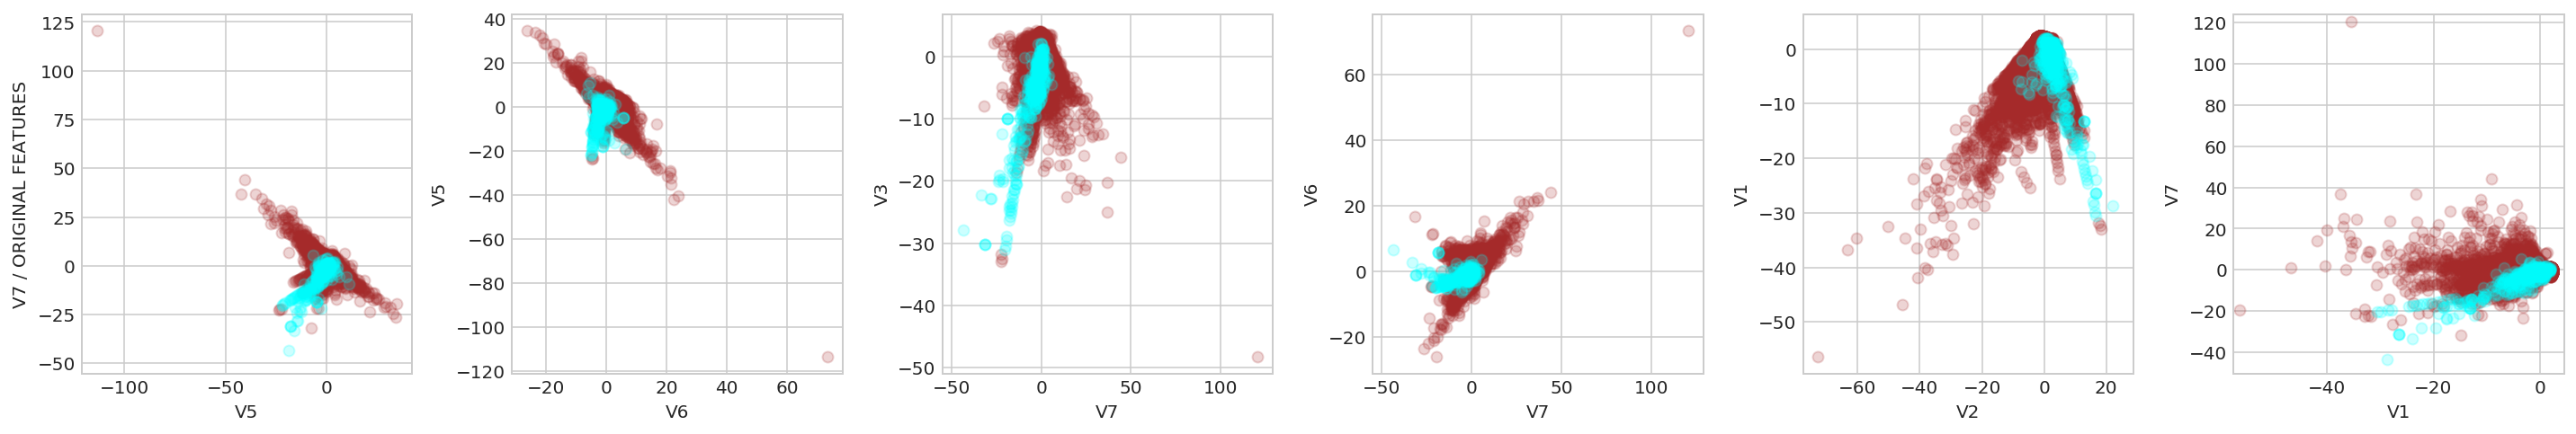

In [58]:
plt.figure(figsize=(20, 13))
labels = ['non_fraud', 'fraud']; colors = ['brown', 'cyan']; lw = 2

for plot in range(6):
    plt.subplot(4, 6, (plot+1))
    for group, color, label, in zip(train_df.groupby('Class'), colors, labels):
        plt.scatter(group[1][corr_top6[plot][0]], group[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / ORIGINAL FEATURES')
        else:
            plt.ylabel(corr_top6[plot][1])

plt.margins(0.02); plt.tight_layout()

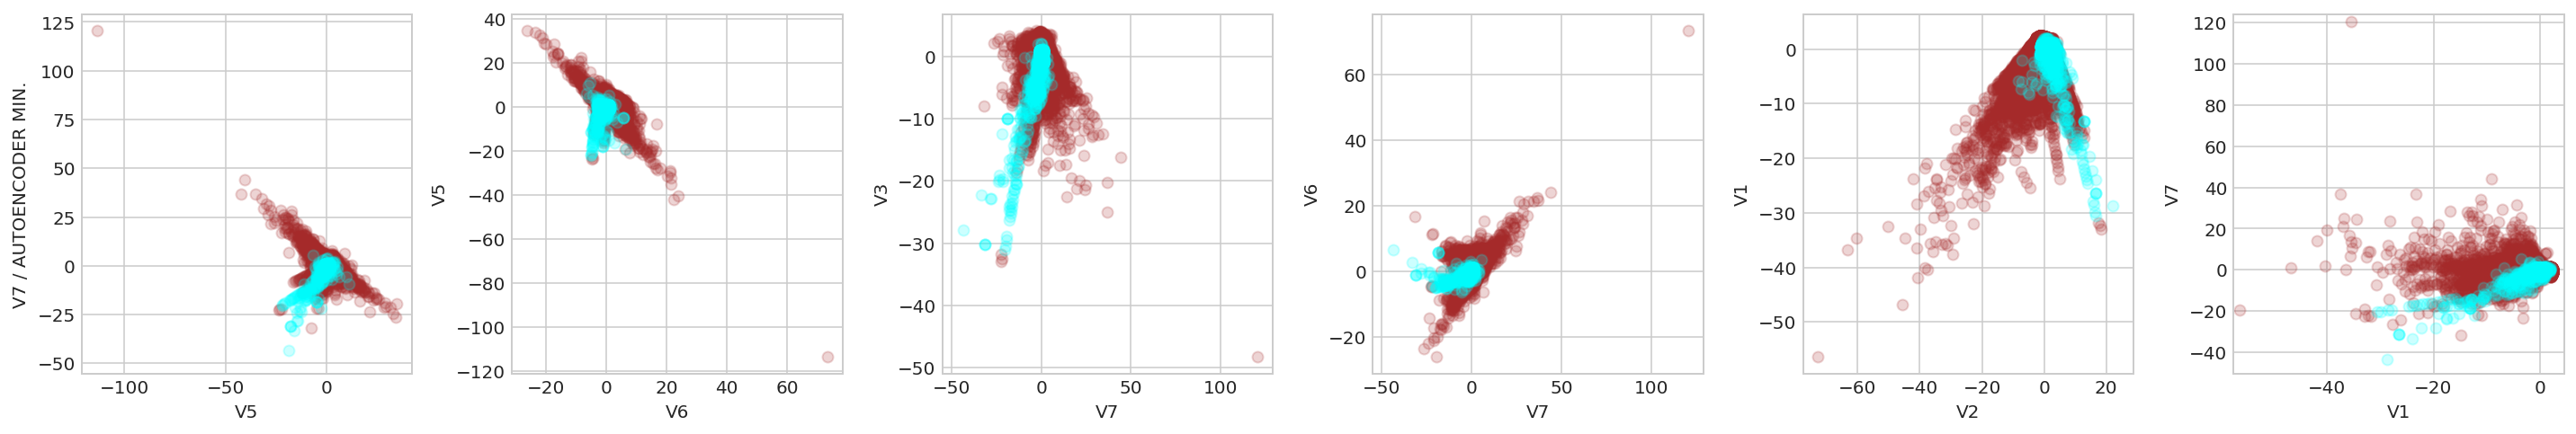

In [59]:
plt.clf()
plt.figure(figsize=(20, 13))
labels = ['non_fraud', 'fraud']; colors = ['brown', 'cyan']; lw = 2

for plot in range(6):
    plt.subplot(4, 6, (plot+7))
    for group_2, color, label, in zip(min_auto_data.groupby('Class'), colors, labels):
        plt.scatter(group_2[1][corr_top6[plot][0]], group_2[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / AUTOENCODER MIN.')
        else:
            plt.ylabel(corr_top6[plot][1])

plt.margins(0.02); plt.tight_layout()

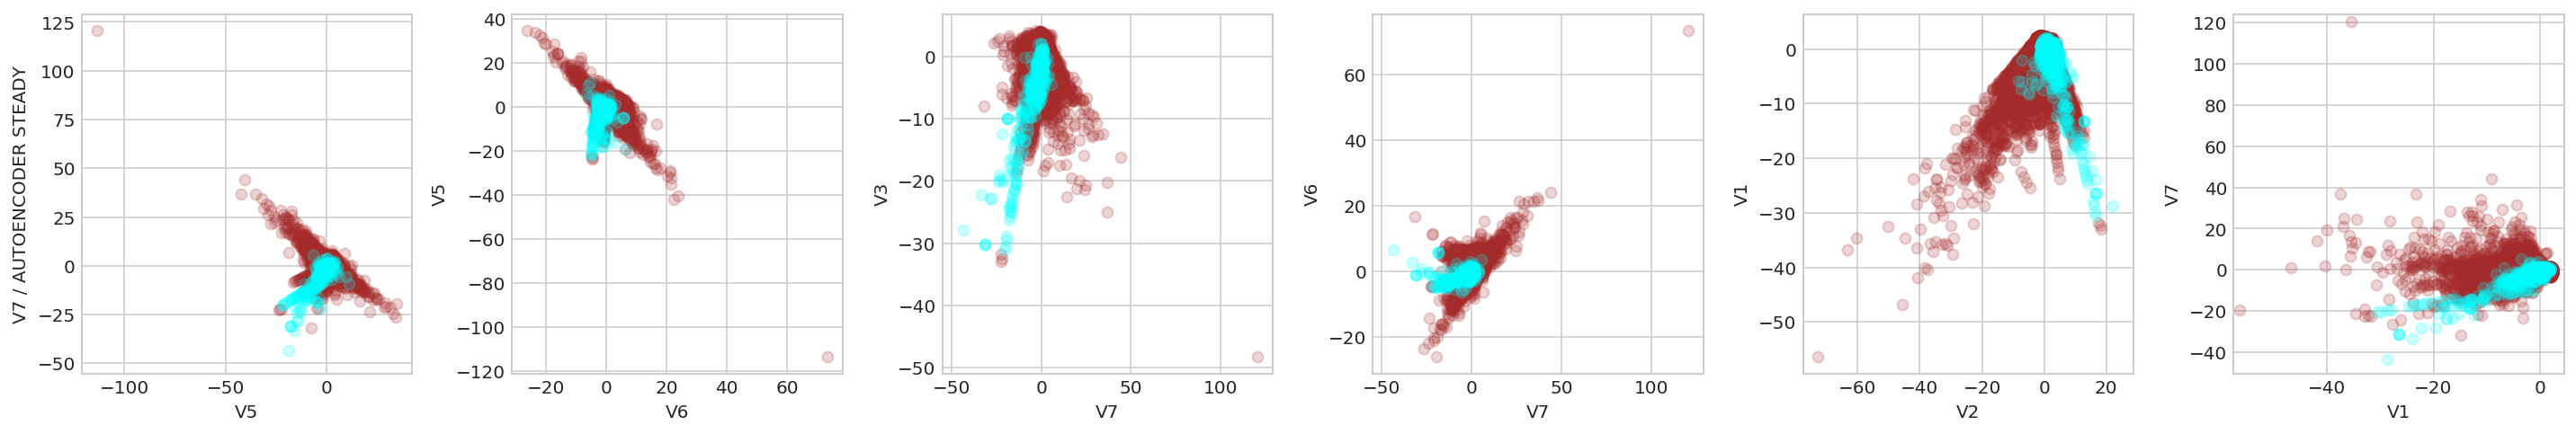

In [60]:
plt.clf()
plt.figure(figsize=(20, 13))
labels = ['non_fraud', 'fraud']; colors = ['brown', 'cyan']; lw = 2

for plot in range(6):
    plt.subplot(4, 6, (plot+13))
    for group_3, color, label, in zip(sdy_auto_data.groupby('Class'), colors, labels):
        plt.scatter(group_3[1][corr_top6[plot][0]], group_3[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / AUTOENCODER STEADY')
        else:
            plt.ylabel(corr_top6[plot][1])
            
plt.margins(0.02); plt.tight_layout()

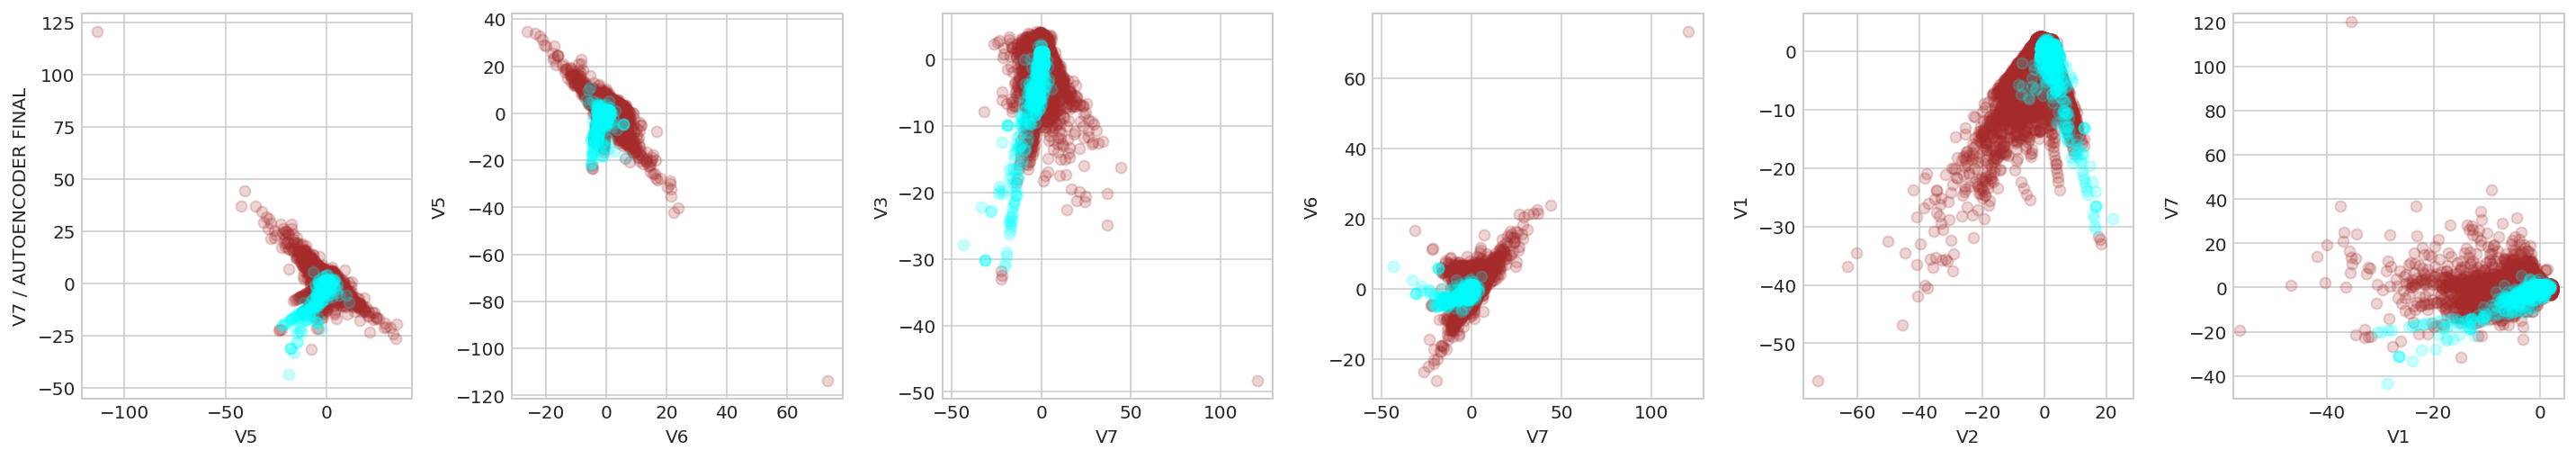

In [61]:
plt.clf()
plt.figure(figsize=(20, 13))
labels = ['non_fraud', 'fraud']; colors = ['brown', 'cyan']; lw = 2

for plot in range(6):
    plt.subplot(4, 6, (plot+19))
    for group_4, color, label, in zip(final_auto_data.groupby('Class'), colors, labels):
        plt.scatter(group_4[1][corr_top6[plot][0]], group_4[1][corr_top6[plot][1]], c=color, alpha=0.2)         
        plt.xlabel(corr_top6[plot][0])
        if plot == 0:
            plt.ylabel(corr_top6[plot][1] + ' / AUTOENCODER FINAL')
        else:
            plt.ylabel(corr_top6[plot][1])

plt.margins(0.02); plt.tight_layout()

While the recall on fraudulent cases are very high, it makes no sense to augment data using autoencoders. Though no visible changes in the scatter relations were observed above _(the changes are exceptionally minor to the eye, enlarge the images to see these minor differences)_, the classification results show very high misclassification rates from the minimal to the final epoch generated data used. This suggests that the generated data is highly overfitting to the training set when an autoencoder is used and this method **should not be used to augment imbalanced datasets at all even if the data reflects a 'true' or stable posterior distribution**.

There is no proper learning of the real data's distributions unlike GANs. To conclude, using an autoencoder's synthetic data is no different from performing random oversampling for numerical-based features as it is unable to generate data to resemble a distribution. It is capable of 'vertically shifting' the distribution upwards rather than scaling it proportionately.

### References
\[1] [Autoencoder Code Reference](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/autoencoder.ipynb)

_**Noteworthy Python Dataset, Library & Tips**_ <br>
\[2] [Understanding Xavier Initialisation](https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/) <br>
\[3] [Source Credit Card Dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud) <br>
\[4] [Original Dataset Contributor & Publication](http://www.ulb.ac.be/di/map/adalpozz/pdf/Dalpozzolo2015PhD.pdf) <br>